# AMG+ for 1D Helmholtz: 4/2 Repetitive Coarsening, 3-level
* Constant $k$. $k h$ designed so that wavelength evenly divides the domain.
* Discretization: 5-point (4th order).
* Kaczmarz relaxation.
* Fixed-domain problem; repetitive, so we sample windows from a test vector.
* Using ideal TVs.
* Interpolation LS fitting is weighted by $\|A x^{(k)}\|^{-1}$, where $k$ runs over test functions, and the norm is local (over 3 aggregates when fitting interpolation in an aggregate). This forces the interpolation row sums to be $1$, as the constant null-space vector has infinite LS weight. Thus $A^c$ is exactly singular and $b^c$ is exactly compatible with it at the coarse level in the cycle.

In [1]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy
import itertools
import helmholtz.analysis.plots

In [2]:
# Fixed seed for reproducible results.
np.random.seed(0)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 4

# Set # sweeps manually here.
num_sweeps_on_vectors = 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge" #"plain"
weighted = False #True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

# Mock cycle/two-level cycle nu value list.
nu_values = np.arange(1, 12)

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513015


## Level 0->1 Coarsening

### Relaxation

In [3]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n)
# Use default = Kacmzarz relaxation for kh != 0.
level = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)

# Initialize hierarchy to 1-level.
finest = 0
multilevel = hm.setup.hierarchy.multilevel.Multilevel.create(level)

# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level.location = np.arange(n)

# TV and TV residual history.
x_log = []
r_log = []

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     1.310e+00                    4.468e-01    2.925
INFO     1     7.259e-01 (0.555) [0.555]    3.426e-01    2.123 (0.725)
INFO     2     4.208e-01 (0.581) [0.568]    2.928e-01    1.447 (0.681)
INFO     3     2.668e-01 (0.635) [0.590]    2.670e-01    1.011 (0.698)
INFO     4     1.851e-01 (0.695) [0.615]    2.515e-01    0.746 (0.739)
INFO     5     1.397e-01 (0.755) [0.641]    2.409e-01    0.589 (0.789)
INFO     6     1.138e-01 (0.815) [0.668]    2.330e-01    0.496 (0.843)
INFO     7     9.689e-02 (0.852) [0.691]    2.267e-01    0.434 (0.876)
INFO     8     8.543e-02 (0.882) [0.713]    2.214e-01    0.392 (0.904)
INFO     9     7.703e-02 (0.902) [0.731]    2.169e-01    0.360 (0.921)
INFO     10    7.057e-02 (0.916) [0.748]    2.129e-01    0.336 (0.934)
INFO     11    6.545e-02 (0.927) [0.763]    2.093e-01    0.317 (0.943)
INFO     12    6.127e-02 (0.936) [0.776]    2.060e-01    0.301 (0.951)
INFO 

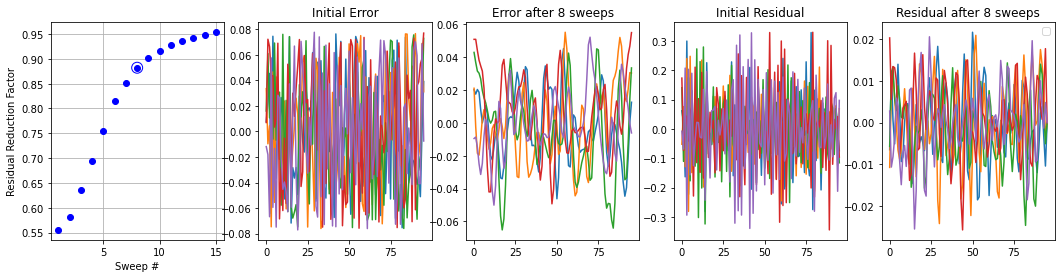

In [4]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    multilevel, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.95, num_examples=5)
num_sweeps = method_info["Kaczmarz"][1]

In [5]:
# Generate animation video of Kaczmarz shrinkage.
# factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history = method_info["Kaczmarz"]
# animation = helmholtz.analyis.plots.animate_shrinkage(factor, num_sweeps, residual, conv, rer, relax_conv_factor, x_history, r_history)
# animation.ipython_display(fps=10, loop=True, autoplay=True)
# animation.write_videofile("laplace_shrinkage.mp4", fps=num_frames // duration)
# animation.write_gif('kaczmarz_shrinkage.gif', fps=num_frames // duration)
# animation.write_gif('kaczmarz_shrinkage.gif', fps=num_frames // duration)

In [6]:
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
level = multilevel[0]
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(level.a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 4 TVs with 100 sweeps
INFO     RER 0.106


### Coarsening: Fixed (4/2)

In [7]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

# Optimize aggregate_size, num_components using mock cycle rates.
# coarsener = hm.setup.coarsening_uniform.UniformCoarsener(
#     level, x, num_sweeps, repetitive=repetitive)
# info = coarsener.get_coarsening_info(1, fmt="dataframe")
# r, aggregate_size, nc, cr, mean_energy_error, mock_conv, mock_work, mock_efficiency = \
#     coarsener.get_optimal_coarsening(1)
# _LOGGER.info("R {} a {} nc {} cr {:.2f} mean_energy_error {:.4f}; mock cycle num_sweeps {} conv {:.2f} "
#              "eff {:.2f}".format(
#     r.shape, aggregate_size, nc, cr, mean_energy_error, num_sweeps, mock_conv, mock_efficiency))
# coarsener.get_coarsening_info(1, fmt="dataframe")

nu  30 s [1.    0.615 0.098 0.013] Energy error [0.529 0.084 0.011 0.   ]
INFO     Mock cycle conv [0.587 0.327 0.187 0.146 0.148 0.125 0.088 0.065 0.063 0.06  0.054]


,0,1,2,3
0,-0.4967,-0.5853,-0.5300,-0.3603
1,0.5976,0.2025,-0.2965,-0.7168


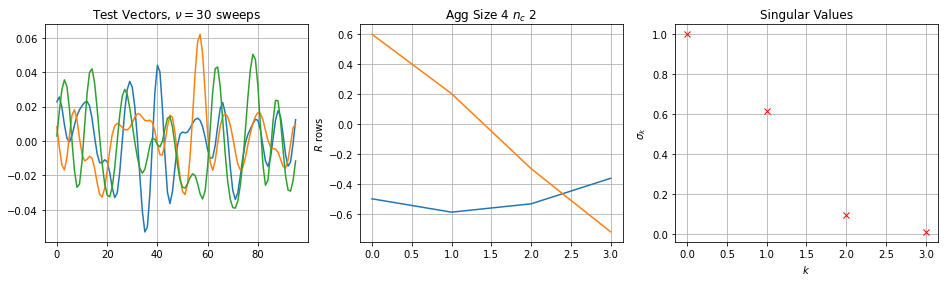

In [8]:
r = helmholtz.analysis.plots.plot_svd_coarsening_accuracy(level, 30, aggregate_size, num_components)
display(pd.DataFrame(r))

In [9]:
aggregate_size, num_components = 4, 2
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
R = r.tile(level.size // aggregate_size)
xc = R.dot(x)
# display(pd.DataFrame(R[:5,:10].todense()))
# hm.repetitive.locality.plot_coarsening(R, x)

### Local Mock Cycle (LMC) Rate
The mock cycle rate is calculated on a domain of size $4 a$, $a$ = aggregate size.

In [10]:
num_sweeps = max(num_sweeps, 7)

In [11]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 5
nu_values = np.arange(1, num_sweeps + 1)
mock_conv = hm.repetitive.locality.mock_conv_factor_for_domain_size(
    kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=20 [0.502 0.34  0.184 0.106 0.151 0.115 0.083 0.067]


### Interpolation $P = R^T$

In [12]:
# Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy(
            kh, discretization, m * aggregate_size, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(n // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(multilevel[0].a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 2.84


### Interpolation by LS Fitting

In [13]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        #print("caliber", caliber)

        p = hm.setup.auto_setup.create_interpolation(
            x, level.a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        #print("p row sums", np.array(p.sum(axis=1)).flatten()[:5])

        # for title, x_set in ((("all", x),) if repetitive else (("fit", x_fit), ("test", x_test))):
        #     error = norm(x_set - p.dot(R.dot(x_set)), axis=0) / norm(x_set, axis=0)
        #     error_a = norm(level.a.dot(x_set - p.dot(R.dot(x_set))), axis=0) / norm(x_set, axis=0)
        #     _LOGGER.info(
        #         "{:<4s} set size {:<2d} P L2 error mean {:.2f} max {:.2f} A error mean {:.2f} max {:.2f}".format(
        #             title, len(error), np.mean(error), np.max(error), np.mean(error_a), np.max(error_a)))

        # Initial guess for interpoation: P = R^T on a single aggregate.
        #display(pd.DataFrame(p[:6, :6].todense()))
        ml = hm.repetitive.locality.create_two_level_hierarchy(
                kh, discretization, n, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

all_conv0 = all_conv

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
Mock,nan,nan,nan,nan,nan,0.5024,0.3396,0.1842,0.1062,0.1506,0.1149,0.0826,0.0668
P=R^T,nan,nan,nan,nan,nan,0.5370,0.4106,0.4274,0.4179,0.3958,0.3624,0.3675,0.3517
P^T A P caliber 2,0.0000,2.0000,192.0000,1.2000,0.0000,0.5234,0.3665,0.4503,0.4705,0.4172,0.4130,0.4116,0.4037
P^T A P caliber 3,0.0000,3.0000,288.0000,1.4000,0.0000,0.6145,0.3378,0.2800,0.3343,0.2867,0.2514,0.2631,0.2554
P^T A P caliber 4,0.0000,4.0000,384.0000,2.0000,0.0000,0.6080,0.3297,0.2101,0.1379,0.1520,0.1349,0.0962,0.0747
R A P caliber 2,1.0000,2.0000,192.0000,1.2000,0.0161,0.5351,0.3736,0.4389,0.4757,0.4117,0.4057,0.4116,0.4018
R A P caliber 3,1.0000,3.0000,288.0000,1.2000,0.0083,0.8612,0.4684,0.4865,0.3891,0.3320,0.3204,0.3303,0.3306
R A P caliber 4,1.0000,4.0000,384.0000,1.2000,0.0035,1.1477,0.5453,0.3949,0.1988,0.1999,0.1602,0.1219,0.0858


* The SVD intepolation is good up to $\nu = 2$, conv $\approx 0.36$. This is similar to the case of Laplace + 2/1 coarsening, where $P$ is only first-order.
* Caliber 2 is equivalent to $P = R^T$.
* Caliber 3 is insufficient, oonly gives marginally better convergence than $P = R^T$.
* Caliber 4 Galerkin gives ideal rates (up to $0.11$).
* Caliber 4 $P$ with $R A P$ is slightly non-symmetric but sparser than $P^T A P$. It gives an intermediate performance between $R A R^R$ and $P^T A P$ (up to $0.18$). 

In [14]:
for use_r_as_restriction in (False, True):
    print("R*A*P" if use_r_as_restriction else "P^T*A*P")

    for caliber, p in zip(calibers, p_experiment[use_r_as_restriction]):
    #    styler = pd.DataFrame(p[:8, :8].todense()).style.set_table_attributes("style='display:inline'").set_caption("Caliber {}".format(caliber)).format(precision=2)   
    #    display_html(styler._repr_html_(), raw=True)
        ml = hm.repetitive.locality.create_two_level_hierarchy(kh, discretization, n, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        print("caliber {} P".format(caliber))
        display(pd.DataFrame(p[:aggregate_size, np.unique(p[:aggregate_size].nonzero()[1])].todense()))
        print("A^1")
        display(pd.DataFrame(ac[:num_components, np.unique(ac[:num_components].nonzero()[1])].todense()))
        #ac2 = ac.transpose().dot(ac)
        #display(pd.DataFrame(ac2.todense()[:14,:14]))

P^T*A*P
caliber 2 P


,0,1
0,0.4205,0.6834
1,0.5534,0.2455
2,0.5627,-0.2390
3,0.4477,-0.6448


A^1


,0,1,2,3,4,5
0,-0.1843,0.0201,0.2106,0.3667,0.2106,-0.3234
1,0.0201,-1.4711,-0.3234,-0.5608,0.3667,-0.5608


caliber 3 P


,0,1,2,3
0,0.4360,0.5917,0.0000,0.0566
1,0.5406,0.3214,0.0000,-0.0469
2,0.5538,-0.3045,-0.0469,0.0000
3,0.4584,-0.5650,0.0571,0.0000


A^1


,0,1,2,3,4,5,6,7
0,-0.1081,0.0182,0.1884,0.2866,0.0034,0.0034,0.1884,-0.2590
1,0.0182,-1.1611,-0.2590,-0.4156,0.0000,0.0000,0.2866,-0.4156


caliber 4 P


,0,1,2,3,4,5
0,0.3741,0.4469,0.0000,0.0000,0.1083,-0.1615
1,0.5846,0.4244,0.0000,0.0000,-0.0836,0.1149
2,0.5997,-0.3980,-0.0787,-0.1145,0.0000,0.0000
3,0.3931,-0.4319,0.1024,0.1629,0.0000,0.0000


A^1


,0,1,2,3,4,5,6,7,8,9
0,-0.0650,0.0173,0.1584,0.2383,0.0102,0.0149,0.0102,-0.0141,0.1584,-0.2190
1,0.0173,-0.9396,-0.2190,-0.3300,-0.0141,-0.0206,0.0149,-0.0206,0.2383,-0.3300


R*A*P
caliber 2 P


,0,1
0,0.4205,0.6834
1,0.5534,0.2455
2,0.5627,-0.2390
3,0.4477,-0.6448


A^1


,0,1,2,3,4,5
0,-0.1827,0.0199,0.2090,0.3640,0.2091,-0.3211
1,0.0254,-1.4700,-0.3281,-0.5690,0.3615,-0.5529


caliber 3 P


,0,1,2,3
0,0.4360,0.5917,0.0000,0.0566
1,0.5406,0.3214,0.0000,-0.0469
2,0.5538,-0.3045,-0.0469,0.0000
3,0.4584,-0.5650,0.0571,0.0000


A^1


,0,1,2,3,4,5
0,-0.1268,0.0194,0.1999,0.3111,0.1997,-0.2781
1,0.0214,-1.2641,-0.2744,-0.4867,0.3028,-0.4791


caliber 4 P


,0,1,2,3,4,5
0,0.3741,0.4469,0.0000,0.0000,0.1083,-0.1615
1,0.5846,0.4244,0.0000,0.0000,-0.0836,0.1149
2,0.5997,-0.3980,-0.0787,-0.1145,0.0000,0.0000
3,0.3931,-0.4319,0.1024,0.1629,0.0000,0.0000


A^1


,0,1,2,3,4,5
0,-0.0363,0.0111,0.1505,0.1776,0.1511,-0.1641
1,0.0145,-0.6401,-0.1661,-0.1662,0.1807,-0.1627


In [15]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P.
p = p_experiment[True][-1]  # R*A*P P high order
#p = p_experiment[True][0]  # R*A*P P=R^T

### Solving $Ax = b$ - Convergence History

#### $R A P$

INFO         0 |r| 1.973e+01 RER 3.66996
INFO         1 |r| 4.823e+00 (0.24450) RER 0.05148 (0.01403) 93.684
INFO         2 |r| 1.300e+00 (0.26962) RER 0.00996 (0.19340) 130.604
INFO         3 |r| 3.969e-01 (0.30525) RER 0.00297 (0.29869) 133.475
INFO         4 |r| 1.473e-01 (0.37103) RER 0.00111 (0.37294) 132.790
INFO         5 |r| 5.357e-02 (0.36371) RER 0.00040 (0.36368) 132.802
INFO         6 |r| 2.027e-02 (0.37840) RER 0.00015 (0.37850) 132.768
INFO         7 |r| 7.501e-03 (0.37009) RER 0.00006 (0.37005) 132.783
INFO         8 |r| 2.808e-03 (0.37436) RER 0.00002 (0.37438) 132.776
INFO         9 |r| 1.057e-03 (0.37638) RER 0.00001 (0.37637) 132.778
INFO        10 |r| 4.092e-04 (0.38714) RER 0.00000 (0.38714) 132.778
INFO        11 |r| 1.601e-04 (0.39130) RER 0.00000 (0.39130) 132.778
INFO        12 |r| 6.294e-05 (0.39307) RER 0.00000 (0.39307) 132.778
INFO        13 |r| 2.454e-05 (0.38998) RER 0.00000 (0.38998) 132.778
INFO        14 |r| 9.407e-06 (0.38326) RER 0.00000 (0.38326) 13

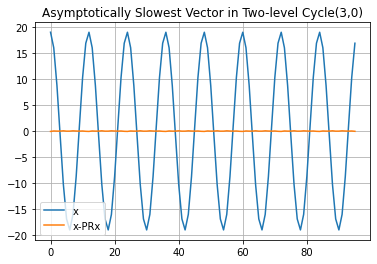

In [16]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 3
use_r_as_restriction = True

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
#y -= y.mean() # Remove zero component.
e = y - m0[1].interpolate(m0[1].coarsen(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [17]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", np.array2string(lam[:12], precision=3))

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.166  0.166]


In [18]:
m0[1].a

<48x48 sparse matrix of type '<class 'numpy.float64'>'
	with 288 stored elements in Compressed Sparse Row format>

In [19]:
pd.set_option("display.precision", 8)
pd.DataFrame(m0[0].a.todense()[2:4, :6])

,0,1,2,3,4,5
0,-0.0833,1.3333,-2.2261,1.3333,-0.0833,0.0000
1,0.0000,-0.0833,1.3333,-2.2261,1.3333,-0.0833


In [20]:
pd.set_option("display.precision", 3)
pd.DataFrame(m0[1].a.todense()[2:4, :6])

,0,1,2,3,4,5
0,0.1511,-0.1641,-0.0363,0.0111,0.1505,0.1776
1,0.1807,-0.1627,0.0145,-0.6401,-0.1661,-0.1662


In [21]:
pd.DataFrame((m0[1].a - m0[1].a.transpose()).todense()[:10, :10])

,0,1,2,3,4,5,6,7,8,9
0,0.0000,-0.0034,-0.0006,-0.0031,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0034,0.0000,-0.0020,-0.0035,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0006,0.0020,0.0000,-0.0034,-0.0006,-0.0031,0.0000,0.0000,0.0000,0.0000
3,0.0031,0.0035,0.0034,0.0000,-0.0020,-0.0035,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0006,0.0020,0.0000,-0.0034,-0.0006,-0.0031,0.0000,0.0000
5,0.0000,0.0000,0.0031,0.0035,0.0034,0.0000,-0.0020,-0.0035,0.0000,0.0000
6,0.0000,0.0000,0.0000,0.0000,0.0006,0.0020,0.0000,-0.0034,-0.0006,-0.0031
7,0.0000,0.0000,0.0000,0.0000,0.0031,0.0035,0.0034,0.0000,-0.0020,-0.0035
8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0006,0.0020,0.0000,-0.0034
9,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0031,0.0035,0.0034,0.0000


<!-- #### $P^T A Q$ Coarsening
This is not exactly a matrix multiplication $P^T A Q$, since $Q$ is not a uni-valued operator. It maps a point at the edge of the stencil of $P^T A$ to two values, one when it's at the edge and one when it's in the middle of the stencil. -->

## Level 1->2 Coarsening
Are the equations at level 1 harder to solve than level 0 because of worse smoothing rates? Do we see a good coarsening ratio for an aggregate of size $4$ here too?

In [22]:
# Coarsening. Force 2 coarse vars per aggregate so we can test alignment.
aggregate_size = 4
num_components = 2

num_sweeps_on_vectors = 100

## Level 1 Relaxation

We run relaxation on $A x = 0$. $A$ has two null vectors; call $Y$ the $n \times 2$ matrix whose columns are these vectors. Let $x_0$ be a random[-1, 1] initial guess for $x$. We first project $x_0$ onto the range of $A$, that is,

$x_0 \longleftarrow x_0 - Y Y^T x_0^T\,,$

and use this as the initial guess for the run. Since the magnitude of $Y$ the exact solution is $0$, and relaxation doesn't change this magnitude, $e = x - x_0$ is a meaningful definition, which can also be used to calculate a meaningful RER.

In [23]:
m1 = m0.sub_hierarchy(1)
level = m1.finest_level
a = level.a

INFO     Kaczmarz
INFO     Iter     |r|                         |x|         RER
INFO     0     2.435e-01                    4.466e-01    0.545
INFO     1     8.874e-02 (0.365) [0.365]    2.728e-01    0.330 (0.608)
INFO     2     4.966e-02 (0.563) [0.451]    2.182e-01    0.229 (0.703)
INFO     3     3.171e-02 (0.641) [0.507]    1.924e-01    0.167 (0.730)
INFO     4     2.458e-02 (0.775) [0.564]    1.752e-01    0.143 (0.853)
INFO     5     1.977e-02 (0.804) [0.605]    1.633e-01    0.123 (0.864)
INFO     6     1.672e-02 (0.845) [0.640]    1.545e-01    0.111 (0.895)
INFO     7     1.455e-02 (0.870) [0.668]    1.476e-01    0.101 (0.912)
INFO     8     1.295e-02 (0.890) [0.693]    1.420e-01    0.094 (0.927)
INFO     9     1.172e-02 (0.905) [0.713]    1.372e-01    0.088 (0.938)
INFO     10    1.074e-02 (0.916) [0.731]    1.331e-01    0.083 (0.946)
INFO     11    9.931e-03 (0.924) [0.747]    1.295e-01    0.079 (0.952)
INFO     12    9.254e-03 (0.931) [0.761]    1.263e-01    0.076 (0.956)
INFO 

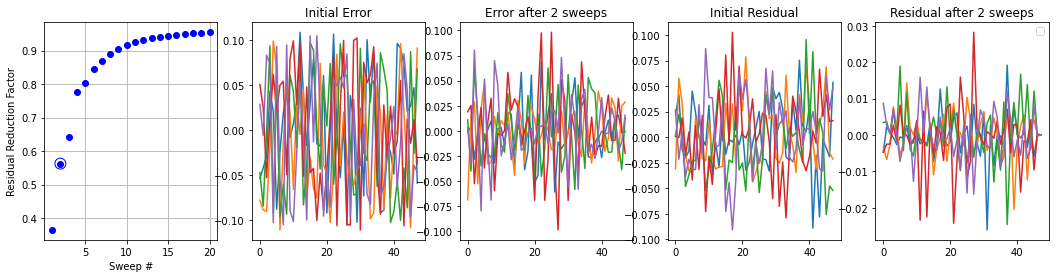

In [24]:
method_info = hm.solve.smoothing.check_relax_cycle_shrinkage(
    m1, num_levels=1, leeway_factor=leeway_factor, slow_conv_factor=0.98, max_sweeps=20)
num_sweeps = method_info["Kaczmarz"][1]

nu 100 s [1.    0.804 0.004 0.   ] Energy error [0.627 0.004 0.    0.   ]
INFO     Mock cycle conv [0.348 0.217 0.147 0.134 0.11  0.094 0.079 0.06  0.053 0.037 0.035]


array([[ 0.66 ,  0.254, -0.669,  0.23 ],
       [-0.486,  0.513, -0.467, -0.531]])

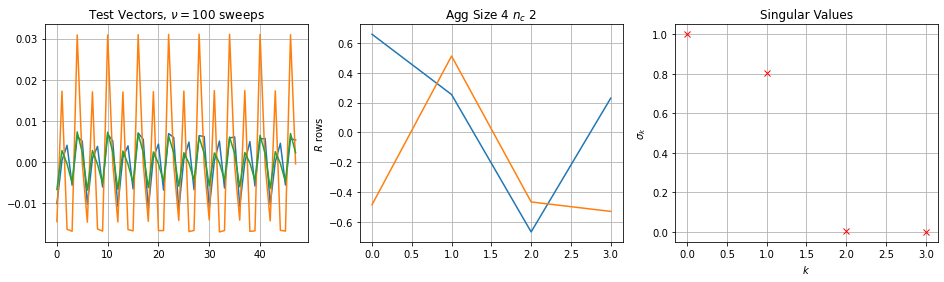

In [25]:

# #PCs revealed by relaxed vectors of increasing smoothness.
helmholtz.analysis.plots.plot_svd_coarsening_accuracy(level, 100, aggregate_size, num_components)

In [26]:
pd.DataFrame(level.a.todense()[10:12, 8:14])

,0,1,2,3,4,5
0,0.1511,-0.1641,-0.0363,0.0111,0.1505,0.1776
1,0.1807,-0.1627,0.0145,-0.6401,-0.1661,-0.1662


In [27]:
ideal_tv = False # True
num_examples = 5
nu = num_sweeps_on_vectors if num_sweeps_on_vectors is not None else num_sweeps
# Generate initial test vectors.
if ideal_tv:
    _LOGGER.info("Generating {} ideal TVs".format(num_examples))
    x, lam = hm.analysis.ideal.ideal_tv(level.a, num_examples)
else:
    _LOGGER.info("Generating {} TVs with {} sweeps".format(num_examples, nu))
    x = hm.setup.auto_setup.get_test_matrix(a, nu, num_examples=num_examples)
    _LOGGER.info("RER {:.3f}".format(norm(level.a.dot(x)) / norm(x)))
x_log.append(x)

INFO     Generating 5 TVs with 100 sweeps
INFO     RER 0.002


In [28]:
#plt.plot(x[:, 0][1::2])
#plt.plot(x[:, 1][1::2])
#plt.plot(x[:, 2][1::2])

#plt.plot(x[:, 1])

In [29]:
# def autocorr(x):
#     result = np.correlate(x, x, mode='full')
#     return result[result.size//2:]

In [30]:
 # np.correlate(x[:, 0], x[:, 0], mode='full')

[1.    0.78  0.006 0.001]
(24, 48)


,0,1,2,3,4,5,6,7,8,9
0,-0.6899,-0.2213,0.6369,-0.2635,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,-0.4427,0.5288,-0.5089,-0.5151,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,-0.6899,-0.2213,0.6369,-0.2635,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,-0.4427,0.5288,-0.5089,-0.5151,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.6899,-0.2213


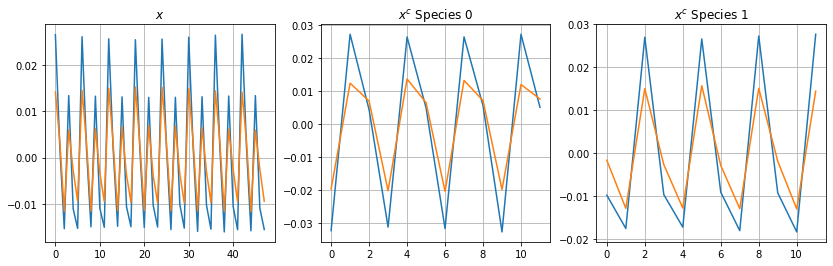

In [31]:
r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
print(s/s[0])
R = r.tile(level.size // aggregate_size)
print(R.shape)
xc = R.dot(x)
display(pd.DataFrame(R[:5,:10].todense()))
hm.repetitive.locality.plot_coarsening(R, x)

### Mock Cycle Rate

In [32]:
# Calculate local mock cycle convergence rate on a domain of size 4 * aggregate_size.
m = 24
mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in nu_values])
#hm.repetitive.locality.mock_conv_factor_for_domain_size(kh, discretization, r, aggregate_size, m * aggregate_size, nu_values)
_LOGGER.info("Mock cycle conv |domain|={} {}".format(
    m * aggregate_size, np.array2string(mock_conv, precision=3)))

INFO     Mock cycle conv |domain|=96 [0.345 0.213 0.152 0.138 0.11  0.096 0.049 0.066]


In [33]:
# hm.setup.geometry.geometric_neighbors_from_locations(location[0], location[1], n, aggregate_size)[:, :4]
# num_aggregates = int(np.ceil(multilevel[0].a.shape[0] / aggregate_size))
# num_coarse_vars = nc * num_aggregates
# np.mod(hm.setup.geometry.geometric_neighbors(aggregate_size, num_components), num_coarse_vars)

### Interpolation $P = R^T$

In [34]:
#### Initial guess for interpoation: P = R^T on a single aggregate.
p = r.tile(1).transpose()

two_level_conv = np.array([
    hm.repetitive.locality.two_level_conv_factor(
        hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
            level.a, level.location, r.asarray(), p, aggregate_size, num_components), 
        nu)[1]
     for nu in nu_values])
conv = pd.DataFrame(np.array((mock_conv, two_level_conv)).transpose(), 
                    index=nu_values, columns=("Mock", "P=R^T")).transpose()

# Compare the L2 projection norm and the A*A'-orthogonal projection norms, which gives an indication
# that the mock cycle rates are guaranteed to be good predictors of the two-level rates [Rob & James].
R = r.tile(level.size // aggregate_size)
_LOGGER.info("L2 projection norm {:.2f} A*A' projection norm {:.2f}".
             format(norm(R.todense(), ord=2), norm((R.dot(level.a)).todense(), ord=2)))

INFO     L2 projection norm 1.00 A*A' projection norm 0.47


### Interpolation by LS Fitting

In [35]:
calibers = (2, 3, 4)
p_experiment = {}
l2c_experiment = {}
coarsening_values = (False, True)
titles = ("P^T A P", "R A P")
for use_r_as_restriction, title in zip(coarsening_values, titles):
    l2c = []
    p_caliber = []
    for caliber in calibers:
        p = hm.setup.auto_setup.create_interpolation(
            x, a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted)
        ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
                level.a, level.location, R, p, aggregate_size, num_components,
                    use_r_as_restriction=use_r_as_restriction)
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in nu_values])
        l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_caliber.append(p)

    p_experiment[use_r_as_restriction] = p_caliber
    l2c_experiment[use_r_as_restriction] = l2c

all_conv = pd.DataFrame(np.array(
    [[np.nan] * 5 + list(row) for row in conv.values] +
    [v for use_r_as_restriction in coarsening_values for v in l2c_experiment[use_r_as_restriction]]), 
                    columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=tuple(conv.index) + tuple("{} caliber {}".format(title, caliber) for title in titles
                          for caliber in calibers))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
Mock,nan,nan,nan,nan,nan,0.3449,0.2129,0.1516,0.1377,0.1101,0.0956,0.0486,0.0658
P=R^T,nan,nan,nan,nan,nan,7.3381,4.8729,4.4440,3.7320,3.1846,2.7010,2.2868,1.9308
P^T A P caliber 2,0.0000,2.0000,96.0000,1.0000,0.0017,7.5321,4.9910,4.5420,3.8184,3.2570,2.7621,2.3383,1.9743
P^T A P caliber 3,0.0000,3.0000,144.0000,1.1667,0.0012,1.1576,0.9333,0.6053,0.4180,0.3404,0.2803,0.2237,0.2053
P^T A P caliber 4,0.0000,4.0000,192.0000,1.6667,0.0007,3.3848,2.0255,0.9527,0.5293,0.2691,0.0874,0.0699,0.0936
R A P caliber 2,1.0000,2.0000,96.0000,1.0000,0.0018,7.4813,4.9344,4.4965,3.7770,3.2219,2.7325,2.3132,1.9529
R A P caliber 3,1.0000,3.0000,144.0000,1.0000,0.0046,2.7469,3.2515,2.3584,1.4303,1.1358,0.9439,0.7446,0.6943
R A P caliber 4,1.0000,4.0000,192.0000,1.0000,0.0412,1.6182,0.8161,0.3555,0.1471,0.0851,0.0575,0.0459,0.0426


### Solving $Ax = b$ - Convergence History

INFO         0 |r| 3.422e+00 RER 0.88386
INFO         1 |r| 2.674e-01 (0.07814) RER 0.05654 (0.06397) 4.730
INFO         2 |r| 9.110e-03 (0.03406) RER 0.00218 (0.03864) 4.171
INFO         3 |r| 9.556e-04 (0.10490) RER 0.00023 (0.10494) 4.169
INFO         4 |r| 8.738e-05 (0.09144) RER 0.00002 (0.09145) 4.169
INFO         5 |r| 6.403e-06 (0.07328) RER 0.00000 (0.07328) 4.169
INFO         6 |r| 6.305e-07 (0.09847) RER 0.00000 (0.09847) 4.169
INFO         7 |r| 5.836e-08 (0.09256) RER 0.00000 (0.09256) 4.169
INFO         8 |r| 4.939e-09 (0.08463) RER 0.00000 (0.08463) 4.169
INFO         9 |r| 4.552e-10 (0.09216) RER 0.00000 (0.09216) 4.169
INFO        10 |r| 4.083e-11 (0.08970) RER 0.00000 (0.08970) 4.169


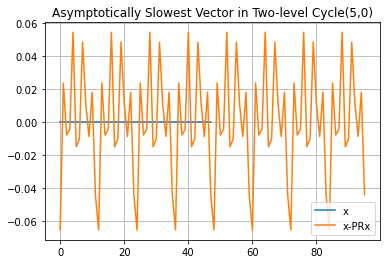

In [36]:
# TODO(orenlivne): define error as (x-x0) projected onto range(a).
nu = 5
p = p_experiment[True][-1]  # P^T*A*P P high order
use_r_as_restriction = True

m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1,
                                                    debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [37]:
pd.DataFrame(m1[1]._r.todense()[:2, :4])

,0,1,2,3
0,-0.6899,-0.2213,0.6369,-0.2635
1,-0.4427,0.5288,-0.5089,-0.5151


In [38]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m1)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.166  0.166]
1 lam [-0.    -0.     0.021  0.021 -0.023 -0.023 -0.04   0.059  0.059 -0.073 -0.073  0.077]


## 3-Level Method

In [39]:
m0.add(m1[1])

INFO         0 |r| 1.629e+01 RER 3.00311
INFO         1 |r| 6.446e-01 (0.03957) RER 0.01879 (0.00626) 34.313
INFO         2 |r| 6.202e-02 (0.09622) RER 0.00175 (0.09324) 35.411
INFO         3 |r| 4.293e-03 (0.06922) RER 0.00012 (0.06939) 35.328
INFO         4 |r| 4.864e-04 (0.11328) RER 0.00001 (0.11325) 35.339
INFO         5 |r| 4.979e-05 (0.10238) RER 0.00000 (0.10238) 35.340
INFO         6 |r| 5.771e-06 (0.11589) RER 0.00000 (0.11589) 35.340
INFO         7 |r| 6.676e-07 (0.11569) RER 0.00000 (0.11569) 35.340
INFO         8 |r| 7.964e-08 (0.11930) RER 0.00000 (0.11930) 35.340
INFO         9 |r| 9.540e-09 (0.11979) RER 0.00000 (0.11979) 35.340
INFO        10 |r| 1.119e-09 (0.11725) RER 0.00000 (0.11725) 35.340
INFO        11 |r| 1.216e-10 (0.10872) RER 0.00000 (0.10872) 35.340
INFO        12 |r| 1.261e-11 (0.10368) RER 0.00000 (0.10368) 35.340


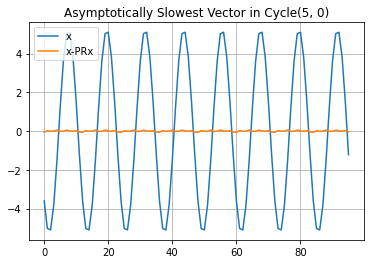

In [40]:
nu_pre = 5
nu_post = 2
y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu_pre, nu_post=nu_post, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Cycle({}, 0)".format(nu_pre, nu_post))
# y -= y.mean() # Remove zero component.
# e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");
plt.grid(True);
plt.legend();

In [41]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", lam[:12])

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.    -0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.152 -0.152  0.166  0.166]
2 lam [-0.    -0.     0.021  0.021 -0.023 -0.023 -0.04   0.059  0.059 -0.073 -0.073  0.077]


In [42]:
# Save A^1 to file.
#scipy.sparse.save_npz('level_1_operator.npz', m0[1].a)

## What are the Coarse Variables?
Given level $l$ and some point $i$,  we look at $P^l P^{l-1} ... P^1 e^l_i$ wheer $e^l_i$ is the $i$th unit vector. There are two species ($i, i+1$) in our setup (4/2 coarsening at all levels). The following matix is level x species.

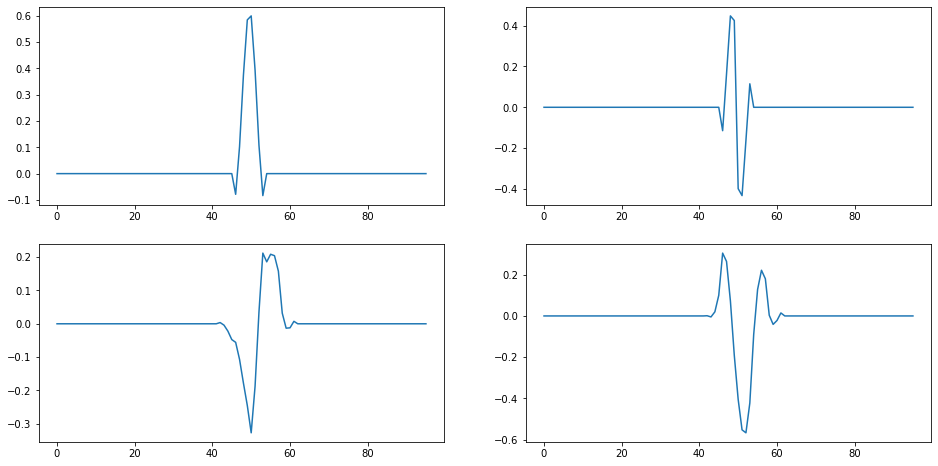

In [43]:
fig, axs = plt.subplots(len(m0) - 1, num_components, figsize=(16, 8))

for l in range(1, len(m0)):
    m = m0[l].size
    i = m // 2
    for col, j in enumerate(range(i, i + num_components)):
        u = np.zeros((m,))
        u[j] = 1
        for ll in range(l, 0, -1):
            u = m0[ll]._p.dot(u)
        axs[l - 1, col].plot(u);

## Symmetrizing $R A P$: Level 0->1

In [44]:
level, coarse_level = m0[:2]

### First experiment: $R -> Q$, $P$ stays fixed
$A^c = QAP$ is symmetric and sparse, but not accurate since $P$ is incompatible with $Q$, so 2-level convergence not that great. Even the first few cycles are slow (maybe the first cycle is OK, but that's it).

In [45]:
r = coarse_level._r
p = coarse_level._p
ap = level.a.dot(p)
q = hm.repetitive.symmetry.symmetrize(r, ap, num_components, aggregate_size)
nu = 5
print("nu", nu)
for title, restriction in (("r", r), ("q", q)):
    print("Restriction", title)
    ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
        level.a, level.location, restriction, p, aggregate_size, num_components, use_r_as_restriction=True)
    ac = ml[1].a
    display(pd.DataFrame(ac.todense()[2:4, :6]))
    display(pd.DataFrame((ac - ac.T).todense()[2:4, :6]))
    y, _ = hm.repetitive.locality.two_level_conv_factor(ml, nu, print_frequency=1, debug=False)

nu 5
Restriction r


,0,1,2,3,4,5
0,0.1511,-0.1641,-0.0363,0.0111,0.1505,0.1776
1,0.1807,-0.1627,0.0145,-0.6401,-0.1661,-0.1662


,0,1,2,3,4,5
0,0.0006,0.0020,0.0000,-0.0034,-0.0006,-0.0031
1,0.0031,0.0035,0.0034,0.0000,-0.0020,-0.0035


INFO         0 |r| 1.930e+01 RER 3.58430
INFO         1 |r| 2.065e+00 (0.10703) RER 0.12181 (0.03399) 16.953
INFO         2 |r| 2.743e-01 (0.13284) RER 0.01515 (0.12439) 18.105
INFO         3 |r| 4.915e-02 (0.17918) RER 0.00276 (0.18246) 17.779
INFO         4 |r| 9.379e-03 (0.19082) RER 0.00053 (0.19069) 17.791
INFO         5 |r| 1.860e-03 (0.19831) RER 0.00010 (0.19832) 17.790
INFO         6 |r| 3.775e-04 (0.20296) RER 0.00002 (0.20296) 17.790
INFO         7 |r| 7.442e-05 (0.19713) RER 0.00000 (0.19712) 17.790
INFO         8 |r| 1.335e-05 (0.17937) RER 0.00000 (0.17937) 17.790
INFO         9 |r| 2.438e-06 (0.18262) RER 0.00000 (0.18262) 17.790
INFO        10 |r| 5.152e-07 (0.21135) RER 0.00000 (0.21135) 17.790
INFO        11 |r| 1.090e-07 (0.21158) RER 0.00000 (0.21158) 17.790
INFO        12 |r| 2.203e-08 (0.20215) RER 0.00000 (0.20215) 17.790
INFO        13 |r| 4.364e-09 (0.19805) RER 0.00000 (0.19805) 17.790
INFO        14 |r| 8.637e-10 (0.19792) RER 0.00000 (0.19792) 17.790
INFO   

,0,1,2,3,4,5
0,0.1508,-0.1619,-0.0364,0.0142,0.1508,0.1800
1,0.1800,-0.1604,0.0142,-0.6292,-0.1619,-0.1604


,0,1,2,3,4,5
0,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000
1,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000


INFO         0 |r| 2.086e+01 RER 3.49622
INFO         1 |r| 2.156e+00 (0.10338) RER 0.10959 (0.03135) 19.676
INFO         2 |r| 3.211e-01 (0.14892) RER 0.02156 (0.19673) 14.895
INFO         3 |r| 6.018e-02 (0.18739) RER 0.00380 (0.17631) 15.831
INFO         4 |r| 1.149e-02 (0.19088) RER 0.00073 (0.19076) 15.841
INFO         5 |r| 2.364e-03 (0.20580) RER 0.00015 (0.20606) 15.822
INFO         6 |r| 4.917e-04 (0.20801) RER 0.00003 (0.20799) 15.823
INFO         7 |r| 1.033e-04 (0.21006) RER 0.00001 (0.21006) 15.823
INFO         8 |r| 2.154e-05 (0.20852) RER 0.00000 (0.20852) 15.823
INFO         9 |r| 4.395e-06 (0.20404) RER 0.00000 (0.20404) 15.823
INFO        10 |r| 8.774e-07 (0.19963) RER 0.00000 (0.19963) 15.823
INFO        11 |r| 1.742e-07 (0.19854) RER 0.00000 (0.19854) 15.823
INFO        12 |r| 3.534e-08 (0.20291) RER 0.00000 (0.20291) 15.823
INFO        13 |r| 7.302e-09 (0.20660) RER 0.00000 (0.20660) 15.823
INFO        14 |r| 1.516e-09 (0.20755) RER 0.00000 (0.20755) 15.823
INFO   

In [46]:
r = coarse_level._r
p = coarse_level._p
ap = level.a.dot(p)
q = hm.repetitive.symmetry.symmetrize(r, ap, num_components, aggregate_size)

l2c = []
slowest_vector = []

for title, restriction in (("r", r), ("q", q)):
    #print("Restriction", title)
    ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
        level.a, level.location, restriction, p, aggregate_size, num_components, use_r_as_restriction=True)
    ac = ml[1].a
    fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
    symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
    two_level_result = [
        hm.repetitive.locality.two_level_conv_factor(
            ml, nu_pre=0, nu_post=nu, print_frequency=None, debug=False)
         for nu in nu_values]
    two_level_conv = np.array([row[1] for row in two_level_result])
    slowest_vector.append([row[0] for row in two_level_result])
    l2c.append([use_r_as_restriction, caliber, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))

l2c = all_conv0.loc[["Mock"]].values.tolist() + l2c
all_conv = pd.DataFrame(l2c, columns=("R A P", "Caliber", "nnz(P)", "Fill-in", "Symmetry") + tuple(nu_values), 
                        index=("Mock",) + tuple(titles))
styler = all_conv.style.set_caption("Convergence Factors").format(precision=4)
display_html(styler._repr_html_(), raw=True)

,R A P,Caliber,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
Mock,nan,nan,nan,nan,nan,0.5024,0.3396,0.1842,0.1062,0.1506,0.1149,0.0826,0.0668
P^T A P,True,4.0000,384.0000,1.2000,0.0035,1.1294,0.4703,0.3208,0.1912,0.2041,0.1588,0.1124,0.0792
R A P,True,4.0000,384.0000,1.2000,0.0000,1.1753,0.5405,0.3952,0.1878,0.2050,0.1598,0.1079,0.0890


### Stencils

#### R

In [47]:
pd.DataFrame(r[:2, :4].todense())

,0,1,2,3
0,0.4179,0.5551,0.5652,0.4448
1,0.6745,0.2526,-0.2324,-0.6536


#### Q

In [48]:
pd.DataFrame(q[:2, :4].todense())

,0,1,2,3
0,0.4301,0.5514,0.5704,0.4306
1,0.6835,0.2511,-0.2204,-0.6486


#### P

In [49]:
pd.DataFrame(ml[1]._p[6:10, 2:6].todense())

,0,1,2,3
0,0.5997,-0.3980,-0.0787,-0.1145
1,0.3931,-0.4319,0.1024,0.1629
2,0.1083,-0.1615,0.3741,0.4469
3,-0.0836,0.1149,0.5846,0.4244


### R A P

In [50]:
pd.DataFrame(r.dot(ml[0].a).dot(ml[1]._p)[4:6, 2:8].todense())

,0,1,2,3,4,5
0,0.1511,-0.1641,-0.0363,0.0111,0.1505,0.1776
1,0.1807,-0.1627,0.0145,-0.6401,-0.1661,-0.1662


#### QAP

In [51]:
pd.DataFrame(q.dot(ml[0].a).dot(ml[1]._p)[4:6, 2:8].todense())

,0,1,2,3,4,5
0,0.1508,-0.1619,-0.0364,0.0142,0.1508,0.1800
1,0.1800,-0.1604,0.0142,-0.6292,-0.1619,-0.1604


### Slowest Component in Cycle 
After removing the null components.

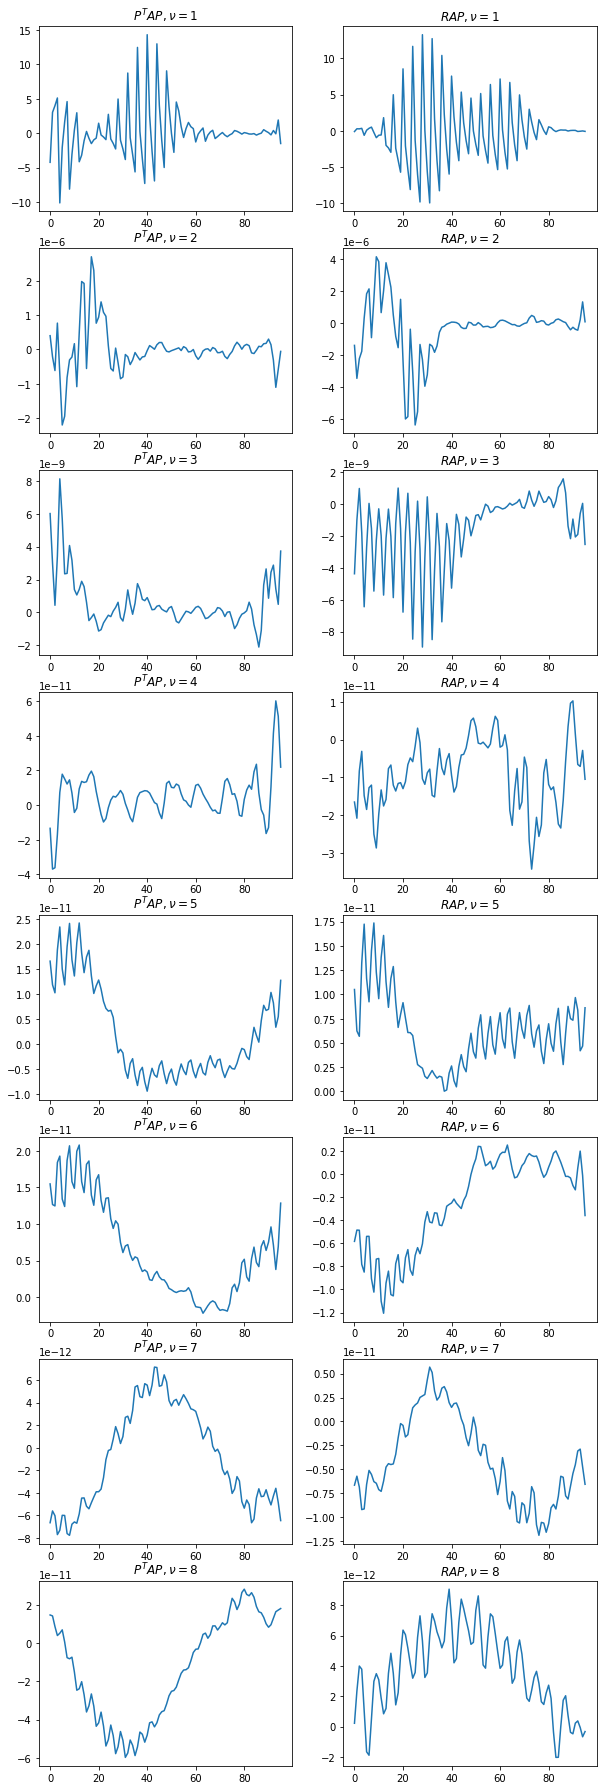

In [52]:
z = hm.analysis.ideal.ideal_tv(ml[0].a, 2)[0]
z[:, 1] -= (z[:, 1].dot(z[:, 0])) * z[:, 0]
z[:, 1] /= norm(z[:, 1])
z.transpose().dot(z)

fig, axs = plt.subplots(len(nu_values), len(titles), figsize=(10, 4 * len(nu_values)))

for row, nu in enumerate(nu_values):
    for col, title in enumerate(titles):
        y = slowest_vector[col][row].copy()
        y -= z.dot(z.transpose().dot(y[:, None])).flatten()
        ax = axs[row][col]
        
        # Asymptotic vector.
        ax.set_title("${}, \\nu = {}$".format(title, nu))
        # y -= y.mean() # Remove zero component.
        # e = y - multilevel[1].p.dot(multilevel[1].r.dot(y))
        ax.plot(y, label="x");
        #ax.plot(e, label="x-PRx");
        #ax.grid(True);
        #ax.legend();

INFO         0 |r| 1.831e+01 RER 3.20943
INFO         1 |r| 2.246e+00 (0.12271) RER 0.00294 (0.00092) 764.625
INFO         2 |r| 7.945e-02 (0.03537) RER 0.00010 (0.03519) 768.480
INFO         3 |r| 4.412e-03 (0.05553) RER 0.00001 (0.05565) 766.834
INFO         4 |r| 2.776e-04 (0.06292) RER 0.00000 (0.06292) 766.842
INFO         5 |r| 2.248e-05 (0.08099) RER 0.00000 (0.08099) 766.844
INFO         6 |r| 1.822e-06 (0.08104) RER 0.00000 (0.08104) 766.844
INFO         7 |r| 1.445e-07 (0.07929) RER 0.00000 (0.07929) 766.844
INFO         8 |r| 1.174e-08 (0.08125) RER 0.00000 (0.08125) 766.844
INFO         9 |r| 9.638e-10 (0.08212) RER 0.00000 (0.08212) 766.844
INFO        10 |r| 8.222e-11 (0.08531) RER 0.00000 (0.08531) 766.844


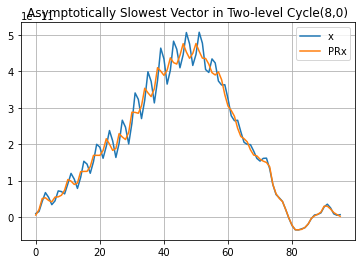

In [53]:
# Example: R with nu=8.
nu = 8
restriction = r
ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, restriction, p, aggregate_size, num_components, use_r_as_restriction=True)
y, _ = hm.repetitive.locality.two_level_conv_factor(
            ml, nu_pre=0, nu_post=nu, print_frequency=1)
y -= z.dot(z.transpose().dot(y[:, None])).flatten()

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
e = ml[1].interpolate(r.dot(y))
plt.plot(y, label="x");
plt.plot(e, label="PRx");
plt.grid(True);
plt.legend();

INFO         0 |r| 1.756e+01 RER 3.27536
INFO         1 |r| 1.717e+00 (0.09774) RER 0.00402 (0.00123) 427.544
INFO         2 |r| 8.437e-02 (0.04915) RER 0.00021 (0.05189) 404.936
INFO         3 |r| 6.455e-03 (0.07650) RER 0.00002 (0.07586) 408.357
INFO         4 |r| 6.023e-04 (0.09331) RER 0.00000 (0.09327) 408.520
INFO         5 |r| 5.346e-05 (0.08876) RER 0.00000 (0.08877) 408.481
INFO         6 |r| 4.879e-06 (0.09127) RER 0.00000 (0.09127) 408.480
INFO         7 |r| 4.685e-07 (0.09602) RER 0.00000 (0.09602) 408.481
INFO         8 |r| 4.390e-08 (0.09371) RER 0.00000 (0.09371) 408.481
INFO         9 |r| 4.167e-09 (0.09492) RER 0.00000 (0.09492) 408.481
INFO        10 |r| 4.071e-10 (0.09769) RER 0.00000 (0.09769) 408.481
INFO        11 |r| 4.048e-11 (0.09943) RER 0.00000 (0.09943) 408.481


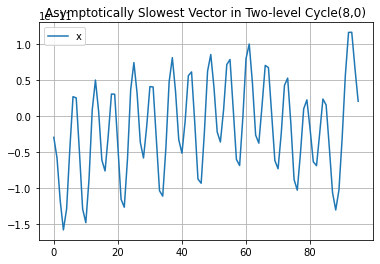

In [54]:
# Example: q with nu=8.
nu = 8
restriction = q
ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level.a, level.location, restriction, p, aggregate_size, num_components, use_r_as_restriction=True)
y, _ = hm.repetitive.locality.two_level_conv_factor(
            ml, nu_pre=0, nu_post=nu, print_frequency=1)
y -= z.dot(z.transpose().dot(y[:, None])).flatten()

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
e = ml[1].interpolate(r.dot(y))
plt.plot(y, label="x");
#plt.plot(e, label="PRx");
plt.grid(True);
plt.legend();